<a href="https://colab.research.google.com/github/rhks13/Anomaly-Detection/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np

In [20]:
import pickle
train_data_dir = '/content/drive/MyDrive/AI/이상 탐지/chfdb_chf01_275_train.pkl'
test_data_dir = '/content/drive/MyDrive/AI/이상 탐지/chfdb_chf01_275_test.pkl'

with open(train_data_dir, 'rb') as f:
  train_raw = pickle.load(f)
with open(test_data_dir, 'rb') as f:
  test_raw = pickle.load(f)

In [35]:
from numpy.random import seed
import tensorflow as tf

In [21]:
df = pd.DataFrame(train_raw)
df

,0,1,2
0,-0.645,0.665,0.0
1,-0.635,0.710,0.0
2,-0.645,0.745,0.0
3,-0.635,0.760,0.0
4,-0.645,0.785,0.0
...,...,...,...
1828,-0.700,0.575,0.0
1829,-0.700,0.600,0.0
1830,-0.735,0.625,0.0
1831,-0.730,0.645,0.0


In [22]:
train = pd.DataFrame(train_raw, columns = ['Target 1','Target 2', 'label']).iloc[:,:2] #라벨 제외시키기
test = pd.DataFrame(test_raw, columns = ['Target 1','Target 2', 'label']).iloc[:,:2]

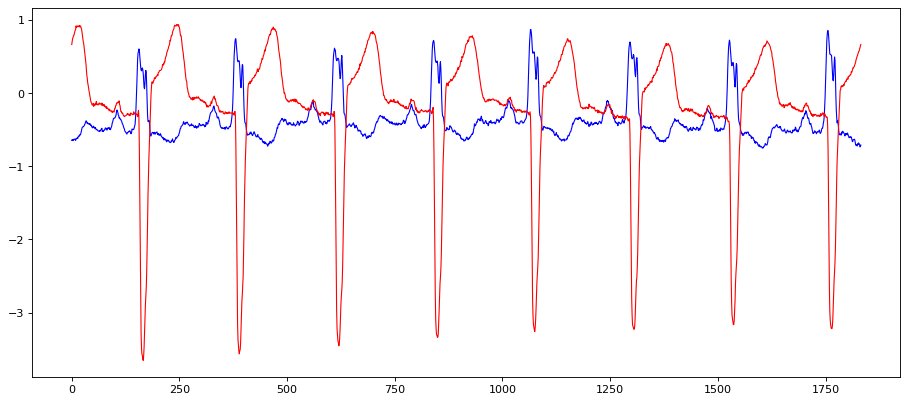

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14,6), dpi = 80)
ax.plot(train['Target 1'], label='Target 1', color = 'blue', animated = True, linewidth = 1)
ax.plot(train['Target 2'], label='Target 2', color = 'red', animated = True, linewidth=1)

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (1833, 1, 2)
Test data shape: (1841, 1, 2)


In [81]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


def lstm_ae(X):
  inputs = Input(shape = (X.shape[1], X.shape[2]))
  L1 = LSTM(24, activation = 'relu', return_sequences = True, kernel_regularizer = regularizers.l2(0.00))(inputs)
  L2 = LSTM(10, activation='relu', return_sequences = False)(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = LSTM(10, activation = 'relu', return_sequences=True)(L3)
  L5 = LSTM(24, activation = 'relu', return_sequences = True)(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)
  model = Model(inputs = inputs, outputs = output)
  return model

In [82]:
model = lstm_ae(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1, 2)]            0         
                                                                 
 lstm_40 (LSTM)              (None, 1, 24)             2592      
                                                                 
 lstm_41 (LSTM)              (None, 10)                1400      
                                                                 
 repeat_vector_10 (RepeatVec  (None, 1, 10)            0         
 tor)                                                            
                                                                 
 lstm_42 (LSTM)              (None, 1, 10)             840       
                                                                 
 lstm_43 (LSTM)              (None, 1, 24)             3360      
                                                           

In [83]:
from tensorflow.keras.callbacks import EarlyStopping
# fit the model to the data
nb_epochs = 200
batch_size = 20
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05, callbacks=[early_stopping]).history

Epoch 1/200
88/88 [==============================] - 7s 22ms/step - loss: 0.4142 - val_loss: 0.3517
Epoch 2/200
88/88 [==============================] - 1s 6ms/step - loss: 0.1869 - val_loss: 0.1973
Epoch 3/200
88/88 [==============================] - 1s 9ms/step - loss: 0.0937 - val_loss: 0.1751
Epoch 4/200
88/88 [==============================] - 1s 10ms/step - loss: 0.0813 - val_loss: 0.1539
Epoch 5/200
88/88 [==============================] - 1s 9ms/step - loss: 0.0718 - val_loss: 0.1479
Epoch 6/200
88/88 [==============================] - 1s 10ms/step - loss: 0.0685 - val_loss: 0.1408
Epoch 7/200
88/88 [==============================] - 1s 7ms/step - loss: 0.0664 - val_loss: 0.1416
Epoch 8/200
88/88 [==============================] - 1s 6ms/step - loss: 0.0655 - val_loss: 0.1329
Epoch 9/200
88/88 [==============================] - 1s 6ms/step - loss: 0.0632 - val_loss: 0.1325
Epoch 10/200
88/88 [==============================] - 1s 7ms/step - loss: 0.0619 - val_loss: 0.1268
Epoch 

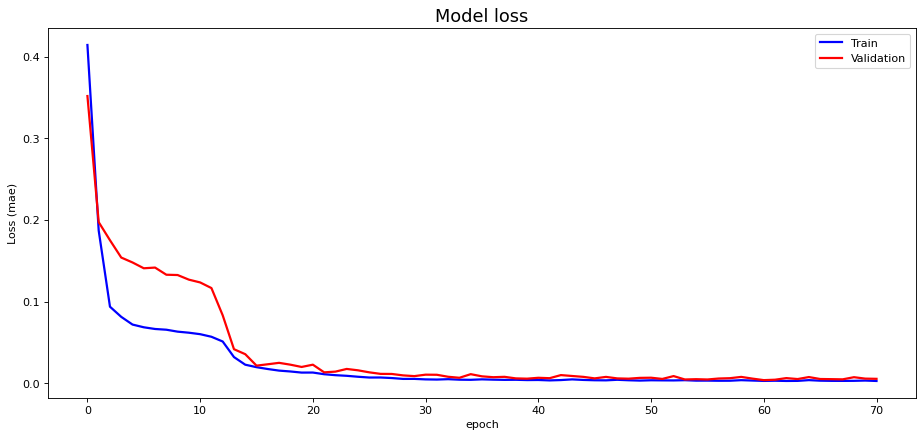

In [84]:
fig, ax = plt.subplots(figsize = (14,6), dpi=80)
ax.plot(history['loss'], 'b', label= 'Train', linewidth=2)
ax.plot(history['val_loss'],'r', label = 'Validation', linewidth=2)
ax.set_title('Model loss',fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('epoch')
ax.legend(loc = 'upper right')
plt.show()

58/58 [==============================] - 1s 2ms/step


<ipython-input-85-453fb3a8d967>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


(0.0, 0.1)

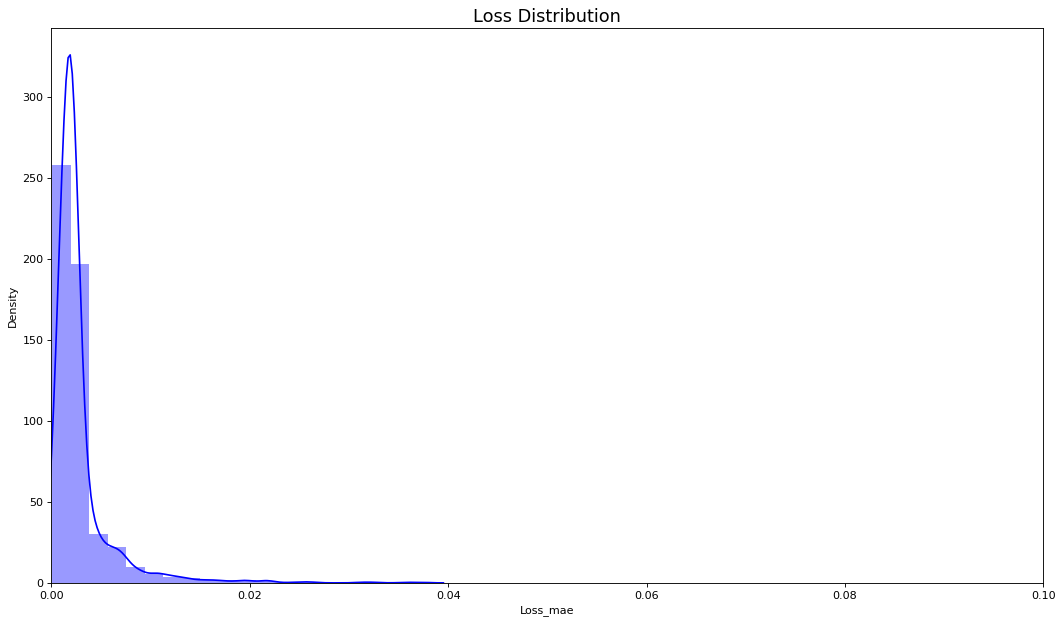

In [85]:
import seaborn as sns

# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,0.1])

In [86]:
# calculate the loss on the test set
print('anomaly threshold = {}'.format(np.percentile(scored,100)))
threshold = np.percentile(scored,100)

X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

anomaly threshold = 0.037361858556527516
58/58 [==============================] - 0s 2ms/step


,Loss_mae,Threshold,Anomaly
0,0.001724,0.037362,False
1,0.001856,0.037362,False
2,0.002444,0.037362,False
3,0.002182,0.037362,False
4,0.002356,0.037362,False


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:698: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(self.ylim)


<Axes: >

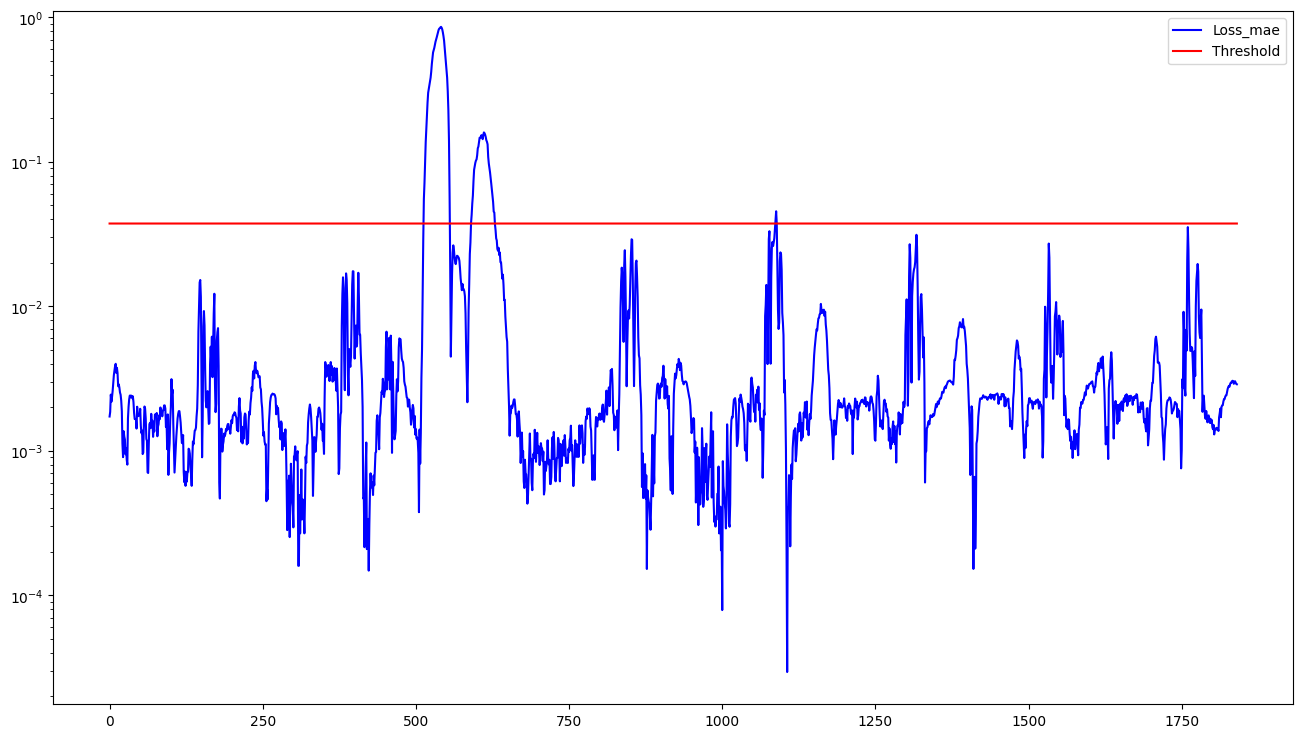

In [87]:
scored.plot(logy=True,  figsize=(16,9), ylim=[0,1.10], color=['blue','red'])

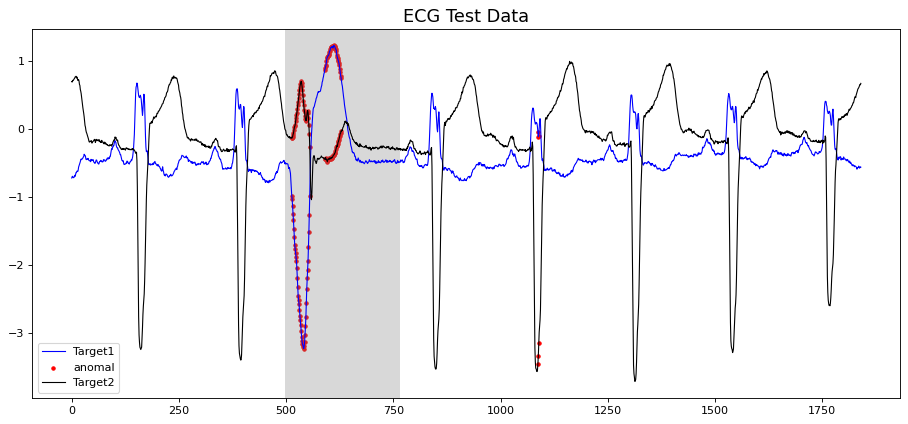

In [88]:
#whole test data
test_ = pd.DataFrame(test_raw,columns=['Target1','Target2','label'])

#make plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target1'].index,test_[scored['Anomaly']==1]['Target1'],label='anomal',marker='.', color='red')
ax.plot(test_['Target2'], label='Target2', color='black', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target2'].index,test_[scored['Anomaly']==1]['Target2'], marker='.', color='red')
plt.legend(loc='lower left')
ax.set_title('ECG Test Data', fontsize=16)
plt.axvspan(min(test_[test_['label']==1].index), max(test_[test_['label']==1].index), facecolor='gray', alpha=0.3)

plt.show()

In [70]:
# save all model information, including weights, in h5 format
model.save("/content/drive/MyDrive/AI/이상탐지/LSTM_AE.h5")
print("Model saved")

Model saved


In [95]:
pd.DataFrame(test_raw)[500:]

,0,1,2
500,-0.505,-0.065,1.0
501,-0.510,-0.085,1.0
502,-0.510,-0.080,1.0
503,-0.510,-0.095,1.0
504,-0.515,-0.110,1.0
...,...,...,...
1836,-0.555,0.625,0.0
1837,-0.575,0.645,0.0
1838,-0.565,0.660,0.0
1839,-0.555,0.655,0.0


모델의 노드 수를 늘린다면?

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1, 2)]            0         
                                                                 
 lstm_32 (LSTM)              (None, 1, 48)             9792      
                                                                 
 lstm_33 (LSTM)              (None, 20)                5520      
                                                                 
 repeat_vector_8 (RepeatVect  (None, 1, 20)            0         
 or)                                                             
                                                                 
 lstm_34 (LSTM)              (None, 1, 20)             3280      
                                                                 
 lstm_35 (LSTM)              (None, 1, 48)             13248     
                                                           

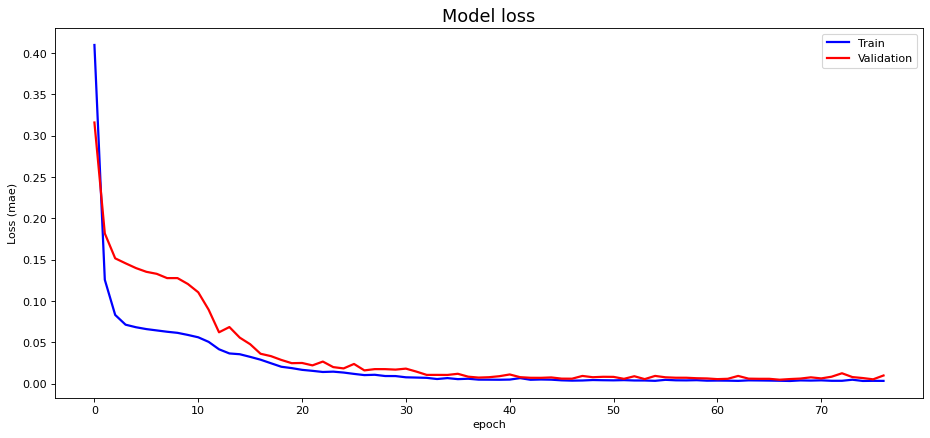

In [75]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


def lstm_ae(X):
  inputs = Input(shape = (X.shape[1], X.shape[2]))
  L1 = LSTM(48, activation = 'relu', return_sequences = True, kernel_regularizer = regularizers.l2(0.00))(inputs)
  L2 = LSTM(20, activation='relu', return_sequences = False)(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = LSTM(20, activation = 'relu', return_sequences=True)(L3)
  L5 = LSTM(48, activation = 'relu', return_sequences = True)(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)
  model = Model(inputs = inputs, outputs = output)
  return model

model = lstm_ae(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

from tensorflow.keras.callbacks import EarlyStopping
# fit the model to the data
nb_epochs = 200
batch_size = 20
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05, callbacks=[early_stopping]).history

fig, ax = plt.subplots(figsize = (14,6), dpi=80)
ax.plot(history['loss'], 'b', label= 'Train', linewidth=2)
ax.plot(history['val_loss'],'r', label = 'Validation', linewidth=2)
ax.set_title('Model loss',fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('epoch')
ax.legend(loc = 'upper right')
plt.show()

58/58 [==============================] - 1s 2ms/step


<ipython-input-76-453fb3a8d967>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


(0.0, 0.1)

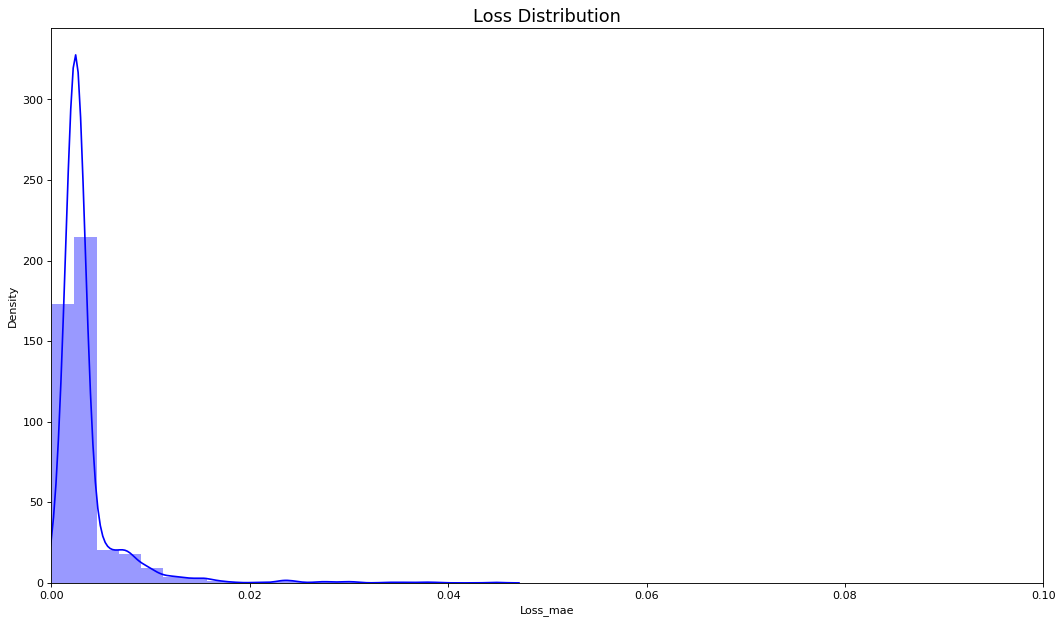

In [76]:
import seaborn as sns

# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,0.1])

anomaly threshold = 0.04477819628502788
58/58 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:698: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(self.ylim)


<Axes: >

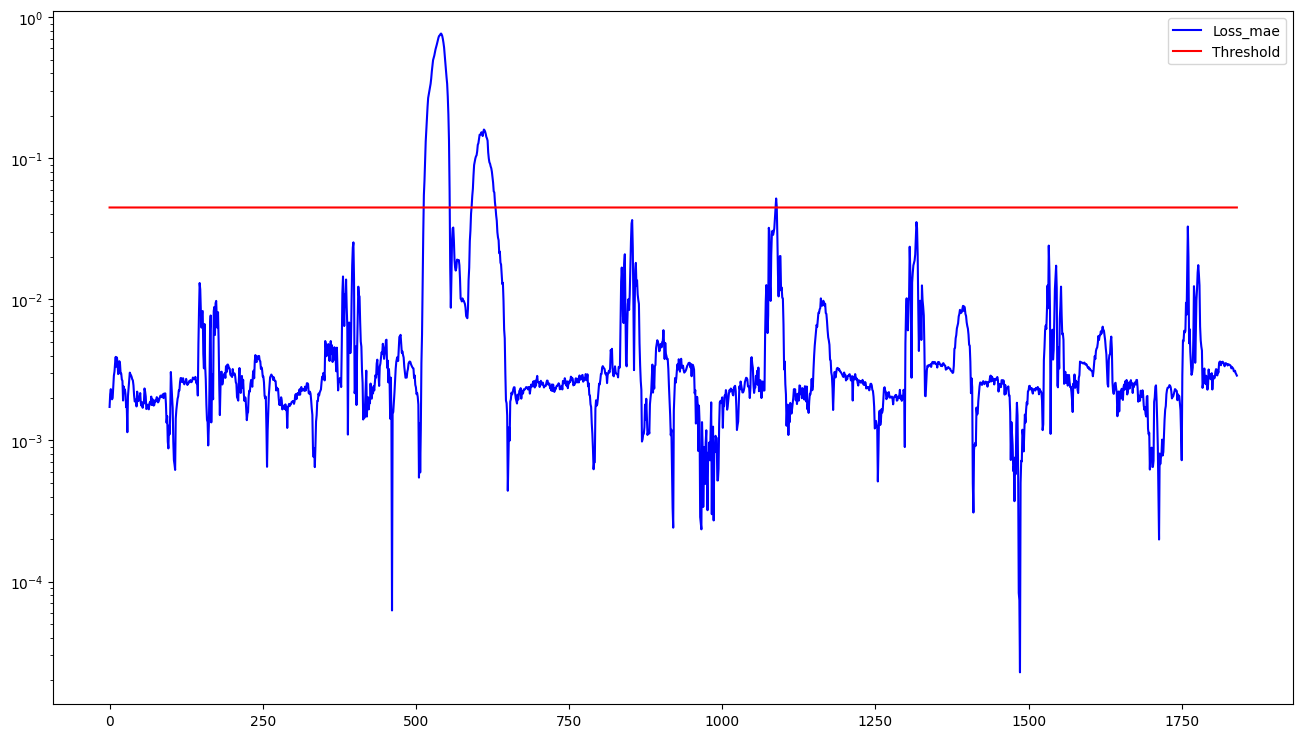

In [77]:
# calculate the loss on the test set
print('anomaly threshold = {}'.format(np.percentile(scored,100)))
threshold = np.percentile(scored,100)

X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']

scored.plot(logy=True,  figsize=(16,9), ylim=[0,1.10], color=['blue','red'])

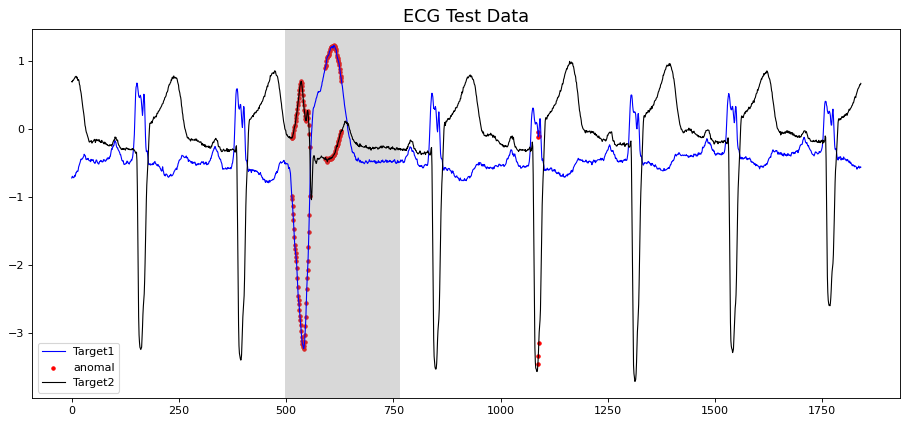

In [78]:
#whole test data
test_ = pd.DataFrame(test_raw,columns=['Target1','Target2','label'])

#make plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target1'].index,test_[scored['Anomaly']==1]['Target1'],label='anomal',marker='.', color='red')
ax.plot(test_['Target2'], label='Target2', color='black', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target2'].index,test_[scored['Anomaly']==1]['Target2'], marker='.', color='red')
plt.legend(loc='lower left')
ax.set_title('ECG Test Data', fontsize=16)
plt.axvspan(min(test_[test_['label']==1].index), max(test_[test_['label']==1].index), facecolor='gray', alpha=0.3)

plt.show()